# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [2]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

#Para el ejercicio 2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve

import sklearn.model_selection
from scipy.stats import randint as sp_randint

# Ejercicio Opcional
from arbolDeDecision import MiClasificadorArbol
from arbolDeDecision import imprimir_arbol

In [3]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego.     
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")

display(X)
display(y)

#display(len(X_train))
#display(len(X_test))

#pd.plotting.scatter_matrix(X, c=y, s=80, figsize=(15, 8), marker='o', alpha=.8);

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

Para poder tomar los datos de desarrollo y evaluación, decidimos utilizar la varianza de los atributos como una primera manera de discriminar los datos.Notamoss que la varianza de los datos era muy igual y muy pocos "minions" tenían una varianza "grande" (mayor a 1.2). Al momento de analizar los datos, descubrimos que si bien estábamos tomando una muestra del 10% de la población, esta muestra de evaluación, no contenía la misma proporción que la población total de datos. De esta manera, decidimos cambiar la forma de separar los datos y decidimos tomar un 10% de los datos positivos y un 10% de los datos negativos. Para poder hacer esto, tomamos la cantidad de datos Positivos y negativos, guardando en 2 listas, los indices de donde se encuentran. Una vez hecho esto, tomamos de forma random
los indices correspondientes a los datos positivos y los datos negativos (guardándolos en una lista random_values
). Una vez que guardamos los indices en una lista general, se avanza con la toma de los "minions" de desarrollo y de evaluación. Si el indice del minion se encuentra en la lista random_values, se toma ese "minion" como un "minion" de evaluación, de lo contrario, se lo toma como un "minion" de desarrollo.

### Correcciones para le RTP
Cambiamos nuestra implementacion de la separacion de los datos por **train_test_split**. Ademas usamos el parametro **stratify** que se encarga de hacer lo mismo que haciamos antes.


'#### Data Split ####'

0    244
1    206
Name: output, dtype: int64

0    27
1    23
Name: output, dtype: int64

'#### 0/1 frequency ratio ####'

'## dev ##'

1.1844660194174756

'## eval ##'

1.173913043478261

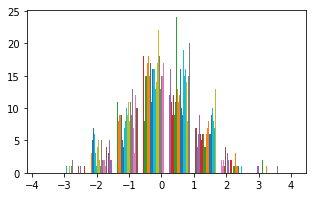

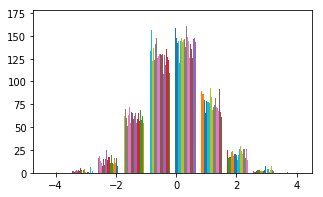

In [4]:
# EJERCICIO 1. 
from sklearn.model_selection import train_test_split
X_dev, X_eval, y_dev, y_eval = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.10)

display("#### Data Split ####")
display(y_dev['output'].value_counts())
display(y_eval['output'].value_counts())

display("#### 0/1 frequency ratio ####")

display("## dev ##")
display(y_dev['output'].value_counts()[0] / y_dev['output'].value_counts()[1])

display("## eval ##")
display(y_eval['output'].value_counts()[0] / y_eval['output'].value_counts()[1])

#Distribucion de los X de evaluacion
plt.figure(figsize=(5, 3))
plt.hist(np.array(X_eval))
plt.show()

#Distribucion de los X de entrenamiento
plt.figure(figsize=(5, 3))
plt.hist(np.array(X_dev))
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.**


### Correciones para el RTP
Ahora usamos predict_proba para calcular el score **AUC_ROC**.

----

In [5]:
### Arbol de sklearn ###
arbol = DecisionTreeClassifier(max_depth=3)

#######################
### Ejercicio Extra ###
#######################

# Descomentar para usar este arbol 
# arbol = MiClasificadorArbol(max_depth=3)

In [6]:
from arbolDeDecision import imprimir_arbol

accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()

arbol.fit(X_dev_np, y_dev_np)

def get_positive_class_probabilities(arr):
    arr_aux = []
    for entry in arr:
        arr_aux.append(entry[1])
    return arr_aux

def get_accuracy(y_pred, y_eval_np):
    return np.mean(y_pred == y_eval_np)
    
def show_prediction_accuracy(y_pred, y_eval_np, x_eval_np):
    print("Predicciones sobre el test set:\n {}".format(y_pred))
    print("Score sobre el test set: {:.2f}".format(np.mean(y_pred == y_eval_np))) # A mano
    print("Score sobre el test set: {:.2f}".format(arbol.score(x_eval_np, y_eval_np))) # Usando el método score.

#Generamos los 5 folds
kf = KFold(n_splits=5)

accuracy_train      = []
accuracy_validation = []
roc_train      = []
roc_validation = []

for train_index, test_index in kf.split(X_dev_np):
    #print("TRAIN:", train_index, "TEST:", test_index)
    kf_X_train, kf_X_test = X_dev_np[train_index], X_dev_np[test_index]
    kf_y_train, kf_y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    # Entrenamos el arbol con el fold actual
    arbol.fit(kf_X_train, kf_y_train)
    
    # Testeamos contra el fold de test para calcular accuracy
    kf_y_pred     = arbol.predict(kf_X_test)
    kf_y_pred_dev = arbol.predict(kf_X_train)
        
    # Calculamos accuracy
    accuracy_validation.append(get_accuracy(kf_y_pred, kf_y_test) )
    accuracy_train.append(get_accuracy(kf_y_pred_dev, kf_y_train) )

    # Testeamos contra el fold de test para calcular el score roc
    kf_y_pred_proba     = arbol.predict_proba(kf_X_test)
    kf_y_pred_dev_proba = arbol.predict_proba(kf_X_train)
    
    # Calculamos roc score
    roc_train.append(sklearn.metrics.roc_auc_score(kf_y_train, get_positive_class_probabilities(kf_y_pred_dev_proba)))
    roc_validation.append(sklearn.metrics.roc_auc_score(kf_y_test, get_positive_class_probabilities(kf_y_pred_proba)))
    
df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"]   = accuracy_train      # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracy_validation # cambiar por accuracies_validation
df["AUC ROC (training)"]    = roc_train           # cambiar por aucs_training
df["AUC ROC (validación)"]  = roc_validation      # cambiar por aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
# df.plot(kind="bar")
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# plt.show()

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8111,0.7000,0.8783,0.7258
2,0.8278,0.6222,0.8741,0.7122
3,0.8222,0.6556,0.8740,0.7103
4,0.8278,0.7222,0.8752,0.7605
5,0.8028,0.6000,0.8571,0.7195


In [7]:
resultados_training   = []
resultados_validation = []

########################################################

np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        
        arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        arbol.fit(X_dev_np, y_dev_np)
        
        #Entrenamiento
        y_pred = arbol.predict_proba(X_dev_np)
        resultados_training.append( sklearn.metrics.roc_auc_score(y_dev_np, get_positive_class_probabilities(y_pred)))
        
        #Validacion
        y_pred = arbol.predict_proba(X_eval_np)
        resultados_validation.append( sklearn.metrics.roc_auc_score(y_eval_np, get_positive_class_probabilities(y_pred)))

#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"]   = resultados_training# reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8604,0.7303
1,5,Gini,0.9527,0.5523
2,Inifinito,Gini,1.0000,0.6932
3,3,Ganancia de Información,0.8388,0.7287
4,5,Ganancia de Información,0.9437,0.7689
5,Inifinito,Ganancia de Información,1.0000,0.6312


### Ejercicio Extra
Para esto tomamos como base el arbol del notebook 4 y lo importamos a un archivo .py para usarlo. 

**Para probarlo, simplemente descomentar la linea del principio de este ejercicio donde se crea el arbol de decision**.

Cambios:
    - En las preguntas comparar por >= para tomar espacios continuos.
    - Agregamos la entropia como calculo de ganancia
    - Agregamos los parametros de profundidad maxima y seleccion de criterio para el arbol. 
    
Obs: Este ej no esta terminado, el arbol todavia tarda mucho en correr.    

### Correcciones para el RTP

Agregamos la posibilidad de usar **predict_proba** para calcular el score **AUC_ROC**.

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [8]:
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##############################################
################# Auxiliares #################
##############################################

def top_resultados(grid, top=5):
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

def bot_resultados(grid, bot=5):
    print("Bot {} combinaciones".format(bot))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=True).head(bot))
    
def correr_y_mostrar(estimator, parameters, folds, top):
    grid = GridSearchCV(estimator, parameters, cv=folds, scoring='roc_auc')
    time_before = time.time()
    grid.fit(X_dev_np, y_dev_np)
    time_after = time.time()
    top_resultados(grid, top)
    bot_resultados(grid, top)
    runtime = (time_after - time_before) * 1000.0 
    return (runtime, grid)

# Para usar en caso de tener probabilidades a priori
priors = [(0.1,0.9),(0.2,0.8),(0.3,0.7),(0.4,0.6),(0.5,0.5),(0.6,0.4),(0.7,0.3),(0.8,0.2),(0.9,0.1)]

### Decision Trees

Para este algoritmo decidimos usar solo los atributos criterio y max_depth, ya que son los mas simples a la hora de explicar como se comportan y como afectas a los datos de entrenamiento.

Sin embargo, al hacer algunas pruebas nos encontramos con otro parametro que nos parecio interesante, a continuacion hacemos los analisis en los dos casos (solo con criterio y max_depth | agregando el nuevo parametro).

In [34]:
parametersDecisionTree = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51)
}

(tiempoDecisionTree, grid_decision_tree) = correr_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree,
    5,
    5
)

parametersDecisionTree2 = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51),
    'min_samples_split':range(2, 30)
}

(tiempoDecisionTree2, grid_decision_tree_2) = correr_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree2,
    5,
    5
)

Top 5 combinaciones


/home/nacho/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,criterion,max_depth,mean_score_validation,mean_score_training
1,entropy,2,0.7531,0.8061
2,entropy,3,0.7388,0.8718
3,entropy,4,0.7328,0.9267
52,gini,3,0.7299,0.8726
51,gini,2,0.7287,0.8089


Bot 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
55,gini,6,0.5937,0.9926
56,gini,7,0.5952,0.9969
59,gini,10,0.6001,0.9994
76,gini,27,0.6035,1.0000
62,gini,13,0.6059,1.0000


Top 5 combinaciones


/home/nacho/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
1343,entropy,48,29,0.7566,0.9538
1063,entropy,38,29,0.7566,0.9538
750,entropy,27,24,0.7566,0.9710
302,entropy,11,24,0.7565,0.9711
946,entropy,34,24,0.7562,0.9710


Bot 5 combinaciones


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
1597,gini,8,3,0.5906,0.9982
1569,gini,7,3,0.5916,0.9963
1568,gini,7,2,0.5924,0.9969
1596,gini,8,2,0.5933,0.9985
1543,gini,6,5,0.5953,0.9920


### Solo con dos parametros

A priori se puede ver que los mejores vs peores resultados tienen profundidades maximas bastante distintas(A excepcion del peor elemento con altura 6, suponemos que fue una muy mala muestra que justo dio ese resultado). Entre los mejores arboles en promedio no superan los 5 niveles, mientras que en los peores suele estar alrededor del 14/15.

Una cosa importante a remarcar es que en los peores arboles, el score del set de entrenamiento es bastante alto (y 1 en varios casos), mientras que en los mejores este baja un poco. Esto se da por la tendencia a overfittear  data rapidamente de estos arboles a medida que aparecen mas niveles (Las hipotesis que toma se vuelven casos mas particulares).

Por como se dan los resultados pareciera que la entropia funciona un poco mejor que gini como criterio, pero suponemos que esto no necesariamente es asi en el caso general. 

### Agregando min_samples_split

Podemos ver que con min_samples_split el arbol se limita a cortar un nodo si hay al menos esa cantidad de samples que caen en el. 

Teniendo lo anterior en cuenta podemos observar que los arboles que dieron los mejores resultados fueron los que tuvieron mayor profundidad y mayor cantidad de samples como minimo para separar un nodo. Nuestra suposicion es que al ser relativamente alta la cantidad minima de splitteo, esto evita overfittear sobre casos no muy normales en los datos y obtener profundidad sobre informacion que es relevante. Pero manteniendo un limite a la hora de crear hipotesis demasiado particulares.

### Naive Bayes

En este estimador solo tomamos las probabilidades a priori de las clases.

In [ ]:
parametersNaiveBayes = {
    'priors':priors
}

(tiempoBayes, grid_bayes) = correr_y_mostrar(
    GaussianNB(), 
    parametersNaiveBayes, 
    5, 
    5
)

A la hora de experimentar con el metodo de Naive Bayes medimos su performance con distintas probabilidades a priori de cada clase. Antes de revisar los resultados teniamos la hipotesis de que el metodo daría mejores resultados cuando las probabilidades a priori se acercaran a la inferidas de los datos de entrenamiento. Sin embargo tanto el score de entrenamiento como de validación resultaron variar muy poco a medida que cambiaban las priors, pese a haber experimentado con un rango bastante disperso.

### KNN

In [ ]:
parametersKNN = {
    'n_neighbors' : list(range(1, 32)),
    'weights'     : ['uniform', 'distance']
}

(tiempoKNN, grid_knn) = correr_y_mostrar(
    KNeighborsClassifier(), 
    parametersKNN, 
    5, 
    10
)

A la hora de analizar la performance de KNN sobre nuestros datos destacamos 2 hiper-parametros que nos parecen escenciales para este algoritmo, que son la cantidad de vecinos mas cercanos a la instacia que se quiere clasificar, y la forma en la que se estima el peso que tiene cada uno de estos vecinos a la hora de decidir como clasificar la instacia. De este último hiper-parametro experimentamos con dos posibles formulas, una es la de considerar uniformente los pesos de los vecinos involucrados, de manera que cada uno tengo la misma influencia a la hora de decidir a que clase pertenece la nueva instancia; la otra fue considerar como de mayor peso a aquellos que se encontraran a menor distancia.

Observamos que en el caso del score obtenido con el conjunto de entrenamiento, siempre se obtuvo una estimación perfecta (de 1) al considerar los pesos en funcion de su distancia. Entendemos que esto ocurre porque al intentar clasificar una instancia ya incluida en el modelo, la distancia con ella mismo al ser cero opaca a todo el resto de los vecinos considerados (sin importar cuantos de estos haya). En cambio tomando los pesos uniformemente, el voto del vecino que se encuentra a distancia cero vale lo mismo que el del resto, y en consecuencia no ocurre un overfitting tan contundente como en el caso anterior.

En el caso del score de validacion notamos que al menos en un principio el parametro que mas diferencia aporta es la cantidad de vecinos. A medida que estos aumentan mayor es el score obtenido en ambas estimaciones de pesos, quizas un poco mejor (al menos en un principio) con pesos segun su distancia sobre los pesos uniformes. Sin embargo estas tendencias iniciales no parecen mantenerse a medida que aumenta la cantidad de vecinos, ambos algoritmos parecen mostrar un rendimiento similar. Otra cuestion que nos llamo la atención es que a veces clasificar viendo menor cantidad de vecinos parece funcionar igual o mejor que viendo mas de ellos, pese a que tiene menor información del entorno.

### SVM

In [ ]:
parametersSVM = {
    'C':[1e-15, 1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1.0],
}

(timepoSVM, grid_svm) = correr_y_mostrar(
    LinearSVC(), 
    parametersSVM, 
    5,
    5
)

Para este algoritmo decidimos usar el parametro C. Este controla el nivel de tolerancia al clasificar erroneamente las muestras, con lo que un C chico generaria un hiperplano con margen mas grande, permitiendo asi una hipotesis mas simple. Por otro lado tomando un C grande, se achica el margen del hiperplano y forzando a clasificar mejor los datos de entrenamiento.

En los resultados se puede ver que con valores grandes de C la muestra tiende a "overfittearse", mientras que con valores mas chicos el score de validacion es mas alto.

### LDA

#### Experimento 1

Para el primero probamos usar los parametros **svd**, **n_components** y **priori**. 

In [ ]:
parametersLDA_svd = {
    'solver'            :['svd'],
    'priors'            :priors,
    'n_components'      :[0, 1, 2, 3, 4, 5, 6],
}

(tiempoLDA_svd, grid_lda_svd) = correr_y_mostrar(
    LDA(),
    parametersLDA_svd,
    5,
    5
)

Nos llama la atencion que todos los scores den iguales variando los parametros(Algo parecido a lo que nos paso en **Naive Bayes**), lo que nos da dos suposiciones: 
- Por como funcione svd, el data set se comporta siempre igual
- Hay algun tema con la tecnica que hace que de siempre lo mismo.

Fuera de esto, podemos ver que el score de training y validacion difieren bastante. A continuacion, vamos a probar con otros solvers para comparar.

#### Experimento 2

En este experimento vamos a usar los solvers **lsqr**(cuadrados minimos) y **eigen**, junto con **priors** y **shrinkage**.

In [ ]:
# probamos con n_components para reduccion pero no afecto
shrinkage = np.linspace(0.1,1.0).tolist()
shrinkage.append('auto')

parametersLDA = {
    "solver": ["lsqr", "eigen"],
    "priors": priors,
    "shrinkage": shrinkage
}

(tiempoLDA, grid_lda) = correr_y_mostrar(
    LDA(),
    parametersLDA,
    5,
    10
)

A simple vista se puede notar la diferencia con **svd**, el peor score aqui es mejor que el mejor de **svd**. 

Por otro lado no parece influir mucho la tecnica que se use, ambos solvers parecen dar buenos resultados mientras que probabilidades a priori mas cercanas al **(0.5, 0.5)** quedan como mejor rankeadas.

Algo importante a resaltar es **shrinkage**, valores mas cercanos al 1 dan muy buenos resultados. Reducen un poco el score en el set de entrenamiento pero el de validacion aumenta casi en un 0.1 comparado con los peores casos. Esto sugiere que el valor optimo esta aproximadamente en 0.75.

### Correcciones para el RTP

Investigamos sobre el parametro **shrinkage**, este es una transformacion que se le aplica a la matriz de covarianza para estimar mejor la matriz de presiscion usada para predecir los datos.
Por otro lado, este parametro funciona mejor cuando la cantidad de instancias de entrenamiento es chica en comparacion con la cantidad de features.

## Ejercicio Extra

**Obs:** 
- RandomizeSearchCV cuenta con el parametro **n_iter** para regular la cantidad de veces que prueba parametros random, esto lo vamos a usar a lo largo de los experimentos.

In [9]:
#Auxiliares para correr randomized search
from scipy.stats import uniform
from scipy.stats import randint

def correr_randomized_y_mostrar(estimator, parameters, folds, top,  iteraciones=None):
    grid = None
    if(iteraciones is None):
        grid = RandomizedSearchCV(estimator, parameters, cv=folds, scoring='roc_auc')
    else:
        grid = RandomizedSearchCV(estimator, parameters, cv=folds, scoring='roc_auc', n_iter=iteraciones)
        
    time_before = time.time()
    grid.fit(X_dev_np, y_dev_np)
    time_after = time.time()
    runtime = (time_after - time_before) * 1000.0
    
    top_resultados(grid, top)
    bot_resultados(grid, top)
    
    return (runtime, grid)

def verTiempo(original, random):
    display("original: {:f}".format(original))
    display("random: {:f}".format(random))
    display("diferencia: {:f}".format( np.absolute(original-random) ))

### Decision Trees

Para este experimento tomamos el arbol de decision con solo 2 parametros que discutimos en la primera parte del ejercicio.

In [36]:
parametersDecisionTree = {
    'criterion':['entropy','gini'],
    'max_depth':randint(1, 200)
}

(tiempoRandomDecisionTree, grid_decision) = correr_randomized_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree,
    5,
    5,
    500
)

verTiempo(tiempoDecisionTree, tiempoRandomDecisionTree)

parametersDecisionTree2 = {
    'criterion':['entropy','gini'],
    'max_depth':randint(1, 200),
    'min_samples_split':uniform(0, 1)
}

(tiempoRandomDecisionTree2, grid_decision_tree_2) = correr_randomized_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree2,
    5,
    5,
    500
)

verTiempo(tiempoDecisionTree2, tiempoRandomDecisionTree2)

Top 5 combinaciones


/home/nacho/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,criterion,max_depth,mean_score_validation,mean_score_training
495,entropy,2,0.7531,0.8061
201,entropy,5,0.7302,0.9738
87,gini,2,0.7287,0.8089
242,gini,2,0.7287,0.8089
225,gini,2,0.7287,0.8089


Bot 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
422,gini,7,0.5795,0.9966
250,gini,8,0.5833,0.9980
39,gini,7,0.5970,0.9967
79,gini,187,0.5983,1.0000
332,gini,72,0.5987,1.0000


'original: 21188.497066'

'random: 113682.530880'

'diferencia: 92494.033813'

Top 5 combinaciones


/home/nacho/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
256,entropy,101,0.1161,0.7669,0.9350
223,entropy,191,0.1228,0.7654,0.9309
464,entropy,91,0.1224,0.7654,0.9309
64,entropy,180,0.0901,0.7651,0.9459
311,entropy,23,0.1010,0.7649,0.9446


Bot 5 combinaciones


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
290,gini,95,0.0041,0.6171,1.0000
111,gini,181,0.0127,0.6210,0.9998
334,gini,132,0.0077,0.6235,1.0000
88,gini,65,0.0133,0.6258,0.9998
317,gini,172,0.0033,0.6261,1.0000


'original: 59616088.875532'

'random: 54145.453691'

'diferencia: 59561943.421841'

Al ser un espacio de busqueda discreto, grid y random search ven los mismos elementos en general. Usando un rango mas grande de elementos en la busqueda aleatoria sobre max_depth, podemos observar que las alturas optimas siguen estando cerca de los primeros valores.

### Naive Bayes

In [ ]:
parametersNaiveBayes = {
    'priors':priors
}

tiempoRandomBayes = correr_randomized_y_mostrar(
    GaussianNB(), 
    parametersNaiveBayes, 
    5, 
    5
)

### KNN

Tomamos como parametros una distribucion aleatoria de todos los vecinos posibles que se pueden tomar (n_neighbors <= 360).

TODO: jugar un poco mas con esto.

In [64]:
from scipy.stats import uniform

parametersKNN = {
    'n_neighbors' : randint(0, 360),
    'weights'     : ['uniform', 'distance'],
    'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size'   : randint(0, 360)
}

(tiempoKNN, grid_knn) = correr_randomized_y_mostrar(
    KNeighborsClassifier(), 
    parametersKNN, 
    5, 
    10
)

Top 10 combinaciones


,algorithm,leaf_size,n_neighbors,weights,mean_score_validation,mean_score_training
9,brute,181,98,distance,0.8360,1.0000
2,ball_tree,39,176,distance,0.8353,1.0000
7,ball_tree,44,98,uniform,0.8351,0.8396
5,auto,344,143,distance,0.8330,1.0000
6,ball_tree,150,216,distance,0.8325,1.0000
1,kd_tree,59,237,uniform,0.8299,0.8296
4,brute,100,349,distance,0.8282,1.0000
8,ball_tree,131,21,distance,0.8235,1.0000
3,kd_tree,298,330,uniform,0.8203,0.8181
0,ball_tree,179,319,uniform,0.8176,0.8199


Bot 10 combinaciones


,algorithm,leaf_size,n_neighbors,weights,mean_score_validation,mean_score_training
0,ball_tree,179,319,uniform,0.8176,0.8199
3,kd_tree,298,330,uniform,0.8203,0.8181
8,ball_tree,131,21,distance,0.8235,1.0000
4,brute,100,349,distance,0.8282,1.0000
1,kd_tree,59,237,uniform,0.8299,0.8296
6,ball_tree,150,216,distance,0.8325,1.0000
5,auto,344,143,distance,0.8330,1.0000
7,ball_tree,44,98,uniform,0.8351,0.8396
2,ball_tree,39,176,distance,0.8353,1.0000
9,brute,181,98,distance,0.8360,1.0000


### SVM

TODO: Seguir experimentando

In [186]:
from scipy.stats import gamma

parametersSVM = {
    'C':gamma(a=1.0, loc=0, scale=0.001)
}

(timepoSVM, grid_svm) = correr_randomized_y_mostrar(
    LinearSVC(), 
    parametersSVM, 
    5,
    5,
    10
)

Top 5 combinaciones


,C,mean_score_validation,mean_score_training
1,0.0007,0.8413,0.9459
8,0.0007,0.8412,0.9446
0,0.0005,0.8406,0.9292
7,0.0004,0.8404,0.9277
6,0.0010,0.8374,0.9563


Bot 5 combinaciones


,C,mean_score_validation,mean_score_training
4,6.4503e-03,0.8082,0.9912
5,3.5839e-03,0.8187,0.9845
2,1.8194e-03,0.8324,0.9723
9,7.4605e-05,0.8341,0.8741
3,1.1457e-04,0.8354,0.8841


### LDA

TODO: Seguir jugando un poco con esto

#### Experimento 1

In [190]:
parametersLDA_svd = {
    'solver'            :['svd'],
    'priors'            :priors,
    'n_components'      :range(10000),
}

(tiempoLDA_svd, grid_lda_svd) = correr_randomized_y_mostrar(
    LDA(),
    parametersLDA_svd,
    5,
    5
)

Top 5 combinaciones


/home/nacho/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,n_components,priors,solver,mean_score_validation,mean_score_training
0,8185,"(0.2, 0.8)",svd,0.6961,0.9928
1,389,"(0.9, 0.1)",svd,0.6961,0.9928
2,6820,"(0.5, 0.5)",svd,0.6961,0.9928
3,7262,"(0.3, 0.7)",svd,0.6961,0.9928
4,7038,"(0.4, 0.6)",svd,0.6961,0.9928


Bot 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,8185,"(0.2, 0.8)",svd,0.6961,0.9928
1,389,"(0.9, 0.1)",svd,0.6961,0.9928
2,6820,"(0.5, 0.5)",svd,0.6961,0.9928
3,7262,"(0.3, 0.7)",svd,0.6961,0.9928
4,7038,"(0.4, 0.6)",svd,0.6961,0.9928


#### Experimento 2

In [189]:
# probamos con n_components para reduccion pero no afecto
parametersLDA = {
    "solver": ["lsqr", "eigen"],
    "priors": priors,
    "shrinkage": uniform(0.1, 0.99)
}

(tiempoLDA, grid_lda) = correr_randomized_y_mostrar(
    LDA(),
    parametersLDA,
    5,
    10
)

Top 10 combinaciones


,priors,shrinkage,solver,mean_score_validation,mean_score_training
0,"(0.4, 0.6)",0.8864,lsqr,0.8373,0.8976
5,"(0.9, 0.1)",0.7221,lsqr,0.8370,0.9292
2,"(0.4, 0.6)",0.5695,lsqr,0.8328,0.9604
9,"(0.4, 0.6)",0.4894,eigen,0.8284,0.9681
4,"(0.9, 0.1)",0.4627,eigen,0.8219,0.9468
1,"(0.8, 0.2)",0.4129,lsqr,0.8177,0.9667
3,"(0.8, 0.2)",0.3730,lsqr,0.8135,0.9695
8,"(0.1, 0.9)",0.3081,lsqr,0.8025,0.9714
7,"(0.5, 0.5)",0.1792,eigen,0.7819,0.9871
6,"(0.3, 0.7)",0.1825,lsqr,0.7817,0.9861


Bot 10 combinaciones


,priors,shrinkage,solver,mean_score_validation,mean_score_training
6,"(0.3, 0.7)",0.1825,lsqr,0.7817,0.9861
7,"(0.5, 0.5)",0.1792,eigen,0.7819,0.9871
8,"(0.1, 0.9)",0.3081,lsqr,0.8025,0.9714
3,"(0.8, 0.2)",0.3730,lsqr,0.8135,0.9695
1,"(0.8, 0.2)",0.4129,lsqr,0.8177,0.9667
4,"(0.9, 0.1)",0.4627,eigen,0.8219,0.9468
9,"(0.4, 0.6)",0.4894,eigen,0.8284,0.9681
2,"(0.4, 0.6)",0.5695,lsqr,0.8328,0.9604
5,"(0.9, 0.1)",0.7221,lsqr,0.8370,0.9292
0,"(0.4, 0.6)",0.8864,lsqr,0.8373,0.8976


## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----

**Obs**: En este ejercicio nos falta comparar random forest y gradient boosting.



In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

def plot_learning_curve(estimator, title, X, y, cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Roc Auc Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


def plot_validation_curve(estimator, X, y, param, paramRange, plotTitle, parametroName):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param, param_range=paramRange,
        cv=5, scoring="roc_auc")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    plt.title(plotTitle)
    plt.xlabel(parametroName)
    plt.ylabel("Roc Auc Score")
    lw = 2
    
    plt.semilogx(paramRange, train_scores_mean, label="Training score",
                 color="red", lw=lw)
    plt.fill_between(paramRange, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="red", lw=lw)
    plt.semilogx(paramRange, test_scores_mean, label="Cross-validation score",
                 color="blue", lw=lw)
    plt.fill_between(paramRange, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="blue", lw=lw)
    plt.legend(loc="best")
    plt.show()

### Primeras curvas de complejidad

Veamos como se comportan las curvas para los parametros de ambos estimadores.

**Nota:** Para el arbol de decision usamos el primero que habiamos probado ya que tiene mejor score.

### SVM

In [ ]:
svm = grid_svm.best_estimator_
plot_validation_curve(svm,X_dev_np, y_dev_np, "C", [pow(10,x/2) for x in range(-12,0)],
                      "Curvas para SVM", "C")


plot_validation_curve(svm,X_dev_np, y_dev_np, "C", [pow(10,x/2) for x in range(-10,-4)],
                      "Curvas para SVM", "C")

En este gráfico se observa como el score de entrenamiento y validación se mantienen en un valor mas o menos constante hasta cierto punto en el que el primero comienza a mejorar bruscamente y el segundo decae. Recordemos que conforme aumenta C también aumenta el interes en ajustar el hiperplano de manera de mejorar la presición y no tanto en perseguir un posible hiperplano que maximice el margen de separación. Esto da lugar a un sobreajuste en el caso de que C se vuelva suficientemente grande, lo que produce que el modelo se construya sobra una hipotesis mas rígida y por ende se alcance un sesgo alto. En consecuencia si bien como resultado conseguimos un score de entrenamiento alto, por fruto del sobreajuste el score de validación se vuelve muy bajo. El mejor modelo parecería conseguirse con un C de aproximadamente 10^-3, en la que se consigue un buen score de entrenamiento, pero aun no se llega a sobreajustar, y el modelo mantiene una varianza decente y se maximiza el score de validación, que es lo que nos deja una pauta mas certera de como puede llegar a trabajar nuestro modelo en la realidad.

### Decision Tree

In [ ]:
decisionTree = grid_decision_tree.best_estimator_
plot_validation_curve(decisionTree,X_dev_np, y_dev_np, "max_depth", range(1,25),
                      "Curvas para Decision Tree", "Profundidad")

Podemos observa como a medida que aumenta la profundidad del árbol aumentamos la performance en los datos de validación y por sobre todo la de los datos de entrenamiento. En un principio en donde ambas curvas son no decrecientes nos encontramos en una situación donde la profundidad no es tan grande y por lo tanto el sesgo tampoco lo es. Sin embargo a cierta profundidad el score en validacón decrece y comienza a ser mas erratico, en estas situación consideramos que nos encontramos en un escenario en la que la varianza es baja y el sesgo es muy alto. Esto también se evidencia en la alta performance que mantiene constante con respecto a los datos de entrenamiento, dando a entender que esta sobreajustando el modelo a ellos. Lo ideal parecería ser quedarnos con un árbol de altura entre aproximadamente 55 en donde el sesgo aun no crecio tanto y a su vez la varianza se mantiene en valores no tan chicos. 

#### Haciendo zoom

In [ ]:
decisionTree = grid_decision_tree.best_estimator_
plot_validation_curve(decisionTree,X_dev_np, y_dev_np, "max_depth", range(1,10),
                      "Curvas para Decision Tree", "Profundidad")

Al realizar un zoom en los hiperparametros, podemos apreciar que la profundidad optima esta alrededor del 4. A partir de este valor se empieza a overfitear los datos de entrenamiento.

### Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

parametrosGB = {
    "loss": ['deviance', 'exponential'],
    "criterion": ['mse', 'friedman_mse'],
    "learning_rate": np.linspace(0.1,1,100), 
    "n_estimators": range(1,150)
}
(tiempo_gb, random_grid_gb) = correr_randomized_y_mostrar(
    GradientBoostingClassifier(), 
    parametrosGB, 
    5, 
    5, 
    50
)

plot_learning_curve(
    random_grid_gb.best_estimator_, 
    "Curva de aprendizaje para gradient boosting",
    X_dev_np, 
    y_dev_np, 
    cv=5
)

#### Analisís

Al obtener los resultados y analizarlos, vemos a primera vista que hay un overfiting completo sobre los datos de entrenamiento. Nuestra hipotesis al respecto es que al generar el busting con esa cantidad de estimadores, el ensamble genera tal overfiting. Para poder probar esto, vamos a generar una nueva prueba en la cual vamos a achicar el nivel de estimadores (5,2,1) para ver si los mismos son los que inciden en este overfiting.


In [ ]:
parametrosGB = {
    "loss": ['deviance', 'exponential'],
    "criterion": ['mse', 'friedman_mse'],
    "learning_rate": np.linspace(0.1,1,100), 
    "n_estimators": [5]
}
(tiempo_gb, random_grid_gb) = correr_randomized_y_mostrar(
    GradientBoostingClassifier(), 
    parametrosGB, 
    5, 
    5, 
    50
)

plot_learning_curve(
    random_grid_gb.best_estimator_, 
    "Curva de aprendizaje para gradient boosting 5 estimadores",
    X_dev_np, 
    y_dev_np, 
    cv=5
)
parametrosGB = {
    "loss": ['deviance', 'exponential'],
    "criterion": ['mse', 'friedman_mse'],
    "learning_rate": np.linspace(0.1,1,100), 
    "n_estimators": [2]
}
(tiempo_gb, random_grid_gb) = correr_randomized_y_mostrar(
    GradientBoostingClassifier(), 
    parametrosGB, 
    5, 
    5, 
    50
)

plot_learning_curve(
    random_grid_gb.best_estimator_, 
    "Curva de aprendizaje para gradient boosting 2 estimadores",
    X_dev_np, 
    y_dev_np, 
    cv=5
)

parametrosGB = {
    "loss": ['deviance', 'exponential'],
    "criterion": ['mse', 'friedman_mse'],
    "learning_rate": np.linspace(0.1,1,100), 
    "n_estimators": [1]
}
(tiempo_gb, random_grid_gb) = correr_randomized_y_mostrar(
    GradientBoostingClassifier(), 
    parametrosGB, 
    5, 
    5, 
    50
)

plot_learning_curve(
    random_grid_gb.best_estimator_, 
    "Curva de aprendizaje para gradient boosting 1 estimador",
    X_dev_np, 
    y_dev_np, 
    cv=5
)

#### Analisís del hiperparametro n_estimators

El parametro n_estimators, caracteriza la cantidad de modelos que se van a generar dentro del esamble, de esta manera al pasar de 5 estimadores a 2 y finalmente a 1, vemos un descenso notorio en el train score, esto es porque al tener pocos modelos, poseemos el sesgo y la varianza del modelo original (sesgo alto) y no se ajustan bien al modelo. Agregando mas estimadores (como el boosting da mas prioridad a los datos mal clasificados en la proxima iteracion) el training score empieza a aumentar significativamente, mientras que el validation score tambien.

##### Sesgo y Varianza
(pendiente)

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
